<a href="https://colab.research.google.com/github/Savitanna/sberbank_data_analysis_06_07_21/blob/master/hw_5_geo_Savitskaya_AV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [ ]:
# HW5 - выполнила Савицкая А.В., выполнены упражнения 1, 2, 4

In [ ]:
!pip install shapely
!pip install mapclassify
!pip install rtree
!pip install geoalchemy2
!pip install pygeos
!pip install geopandas
# установка geopandas, или так: !conda install --channel conda-forge geopandas
!pip install folium

In [ ]:
import geopandas as gpd # аналог pandas в мире гео
gpd.show_versions() # зависимости

In [4]:
import datetime # для работы со временем 
import numpy as np 
import pandas as pd
import shapely
import random

In [5]:
from math import hypot, cos, asin, sqrt
from shapely.geometry import Polygon, Point, LineString

In [46]:
# кратчайшее расстояние над поверхностью земли - с помощью Формула Хаверсина

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)
def get_geodesic_distance(point0, point1):
  latitude0=point0.x
  longitude0=point0.y
  latitude1=point1.x
  longitude1=point1.y
  p = 3.1415926/180     #Pi/180
  a = 0.5 - cos((latitude1 - latitude0) * p)/2 + cos(latitude0 * p) * cos(latitude1 * p) * (1 - cos((longitude0 - longitude1) * p)) / 2
  dif_ret=12742 * asin(sqrt(a)) #2*R*asin...
  return dif_ret

get_geodesic_distance(mipt, kremlin)

20.676951687075476

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
my_path_dir="/content/drive/My Drive/Colab Notebooks/data/big_moscow_data/"

big_moscow_districts = gpd.read_file(my_path_dir+"big_moscow_districts.shp")
big_moscow_districts

FID                                           geometry
0      0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...
1      1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...
2      2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...
3      3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...
4      4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...
..   ...                                                ...
141  141  MULTIPOLYGON (((37.31548 55.61297, 37.31545 55...
142  142  POLYGON ((37.13243 55.59919, 37.13442 55.60066...
143  143  POLYGON ((37.78505 55.61682, 37.78475 55.61683...
144  144  POLYGON ((37.64065 55.61046, 37.63994 55.61011...
145  145  POLYGON ((37.58598 55.63117, 37.58588 55.63087...

[146 rows x 2 columns]

In [ ]:
#big_moscow_districts.boundary[141] # границы конкретного Мультиполигона или Полигона в графике
#big_moscow_districts.boundary[141][1] # границы конкретного Полигона из Мультиполигона
# ts_1=pd.DataFrame(data=(big_moscow_districts.boundary[141][1].xy), index=['x_cor', 'y_cor']).transpose() # перевод в матрицу
#ts_1
# big_moscow_districts.boundary[141][1].xy # получение координат границ конкретного Poligon
# d0_x_test=big_moscow_districts.boundary[141][1].xy[0] # получение х или у конкретного Полигона из Мультипольгона

In [58]:
# случайный выбор полигонов для анализа
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)
len(polygon.boundary.xy[0])

84

In [50]:
# функция для определения полигона/мультиполигона, размера каждого полигона
def size_multipolygos(multipolygos_line_0):
  if multipolygos_line_0.type=='MultiLineString':
    number_polygons_0=len(multipolygos_line_0)
    number_rows_in_polygons_0=np.zeros((1, number_polygons_0))
    for i in range(0, number_polygons_0, 1):
      number_rows_in_polygons_0[0, i]=len(multipolygos_line_0[i].xy[0])
    
  elif multipolygos_line_0.type=='LineString':
    number_polygons_0=1
    number_rows_in_polygons_0=len(multipolygos_line_0.xy[0])
    
  return (number_polygons_0, number_rows_in_polygons_0)
# test_with=big_moscow_districts.boundary[140]
# matrix_size0=size_multipolygos(test_with)
# matrix_size0

In [51]:
# 
def get_k_nearest_neighbours_by_dist(polygon0, polygons_k, k_neighbours, kind_neighbours):
  polygons_k_1=big_moscow_districts[big_moscow_districts['geometry'].isin(polygons_k)]
  polygons_k_1.loc[:,'Distance']=100000 # устанавливаем большое значение
  #polygons_k_1.loc['Distance',:]=0
  #
  # создание исходных массивов-векторов для перебора дистанций
  if kind_neighbours=='by_centroid':
    p_1=polygon0.centroid
    for i_poisk in polygons_k_1.index:
      p_2=polygons_k_1.centroid[i_poisk]
      polygons_k_1.loc[i_poisk,'Distance']=get_geodesic_distance(p_1, p_2)
      #
  elif kind_neighbours=='by_board':
    #
    polygon0_0=polygon0.boundary
    polygon0_0_size=size_multipolygos(polygon0_0) # определяем кол-во полигонов и количество точек в каждом полигоне
    # первая цифра - количество полигонов, вторая - матрица, где указано количество строк/точек в кажодм полигоне
    # далее запускаем цикл по точкам, чтобы найти минимум расстояний: перебираем пары точк, 
    # считаем расстояние и запоминаем минимальное
    for i_p0 in range(0, polygon0_0_size[0], 1): 
      # для всех полигонов polygon0_p0
      if polygon0_0_size[0]==1:   
        # если полигон не является мультиполигоном
        p0_x=polygon0_0.xy[0]
        p0_y=polygon0_0.xy[1]
      elif polygon0_0_size[0]>1:
        p0_x=polygon0_0[i_p0].xy[0]
        p0_y=polygon0_0[i_p0].xy[1]
      #      
      polygon0_p0=gpd.points_from_xy(x=p0_x, y=p0_y)
      #   
      # для всех полигонов polygons_k_0
      for i_poisk in polygons_k_1.index:
        polygons_k_0=polygons_k_1.boundary[i_poisk]
        polygons_k_size=size_multipolygos(polygons_k_0) # определяем кол-во полигонов и количество точек в каждом полигоне
        for i_pk in range(0, polygons_k_size[0], 1):
          # проверка полигон или мультиполигон
          if polygons_k_size[0]==1:
            # если полигон не является мультиполигоном
            pk_x=polygons_k_0.xy[0]
            pk_y=polygons_k_0.xy[1]
          elif polygons_k_size[0]>1:
            pk_x=polygons_k_0[i_pk].xy[0]
            pk_y=polygons_k_0[i_pk].xy[1]
          #
          polygons_pk=gpd.points_from_xy(x=pk_x, y=pk_y)
          # теперь запускаем циклы поиска мин расстояния по границам выдранных p0 и pk
          dist_min=1000000 # устанавливаем нереальное минимальное значение дистанции
          for i in range(0, len(polygon0_p0), 1):
            for j in range(0, len(polygons_pk), 1):
              dist_temp=get_geodesic_distance(polygon0_p0[i], polygons_pk[j])
              dist_min=min(dist_min, dist_temp)
      # end for i_poisk
        polygons_k_1.loc[i_poisk,'Distance']=min(polygons_k_1.loc[i_poisk,'Distance'], dist_min) # обойти надо все полигоны р0, если он мультиполигон
      polygons_k_1.loc[i_poisk,'Distance']=min(polygons_k_1.loc[i_poisk,'Distance'], dist_min)
    # end for i_p0
  polygons_k_1_dist=polygons_k_1.sort_values(by='Distance', ascending=True)
  #polygons_end=big_moscow_districts[big_moscow_districts.index.isin(polygons_k_1_dist.index[0:k_neighbours])]
  polygons_end=polygons_k_1_dist[0:k_neighbours]
  return polygons_end

In [59]:
# k_nearest_neighbours_by_centroid
k_sosedi=10
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k_sosedi, 'by_centroid')
k_nearest_neighbours_by_centroid

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to 

FID                                           geometry   Distance
51    51  POLYGON ((37.52125 55.81730, 37.52076 55.81703...   2.190918
42    42  POLYGON ((37.50350 55.79165, 37.50315 55.79104...   3.536880
54    54  POLYGON ((37.56054 55.84484, 37.55877 55.84410...   3.559112
26    26  POLYGON ((37.52194 55.76151, 37.52183 55.76148...   5.395889
64    64  POLYGON ((37.57377 55.84848, 37.57358 55.84851...   7.604462
1      1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...  10.886207
6      6  POLYGON ((37.55595 55.90956, 37.57054 55.91102...  10.971483
40    40  POLYGON ((37.36889 55.77304, 37.36892 55.77394...  11.280672
88    88  POLYGON ((37.55513 55.67065, 37.55431 55.66989...  12.946257
115  115  POLYGON ((37.62641 55.74598, 37.62633 55.74597...  13.087209

In [60]:
#k_nearest_neighbours_by_board 
k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k_sosedi, 'by_board')
k_nearest_neighbours_by_board

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


FID                                           geometry  Distance
26    26  POLYGON ((37.52194 55.76151, 37.52183 55.76148...  0.000000
54    54  POLYGON ((37.56054 55.84484, 37.55877 55.84410...  0.000000
51    51  POLYGON ((37.52125 55.81730, 37.52076 55.81703...  0.000000
42    42  POLYGON ((37.50350 55.79165, 37.50315 55.79104...  0.000000
40    40  POLYGON ((37.36889 55.77304, 37.36892 55.77394...  4.491126
64    64  POLYGON ((37.57377 55.84848, 37.57358 55.84851...  5.134091
1      1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...  7.535943
6      6  POLYGON ((37.55595 55.90956, 37.57054 55.91102...  8.014392
115  115  POLYGON ((37.62641 55.74598, 37.62633 55.74597...  9.606069
89    89  POLYGON ((37.50654 55.66178, 37.50165 55.65852...  9.850677

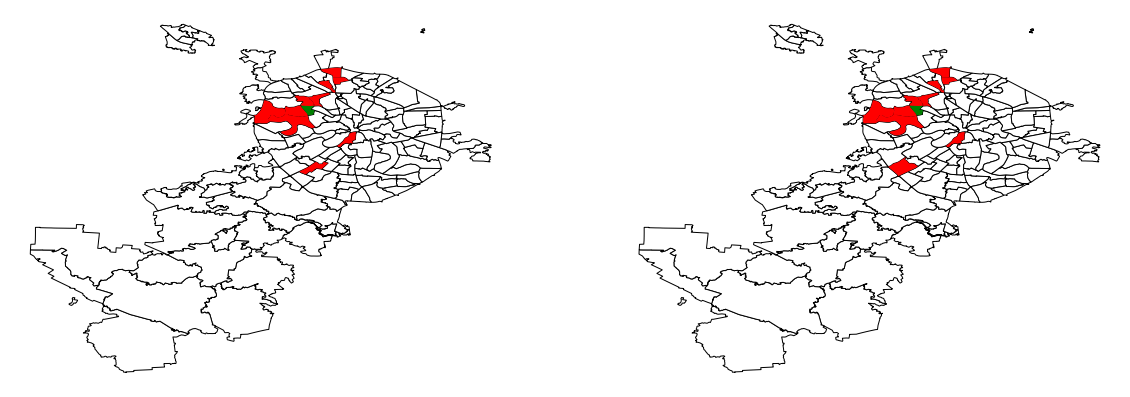

In [61]:
###
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

### Упражнение 3 (*)
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

In [ ]:
# Сигнатура функции и пример вывода:

grid_big_moscow = gpd.read_file('../data/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
mean_resample_table.head()

agg_index                                           geometry  random_value
0          0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...     49.814815
1          1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...     47.923077
2          2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...     45.807692
3          3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...     58.322581
4          4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...     46.446809

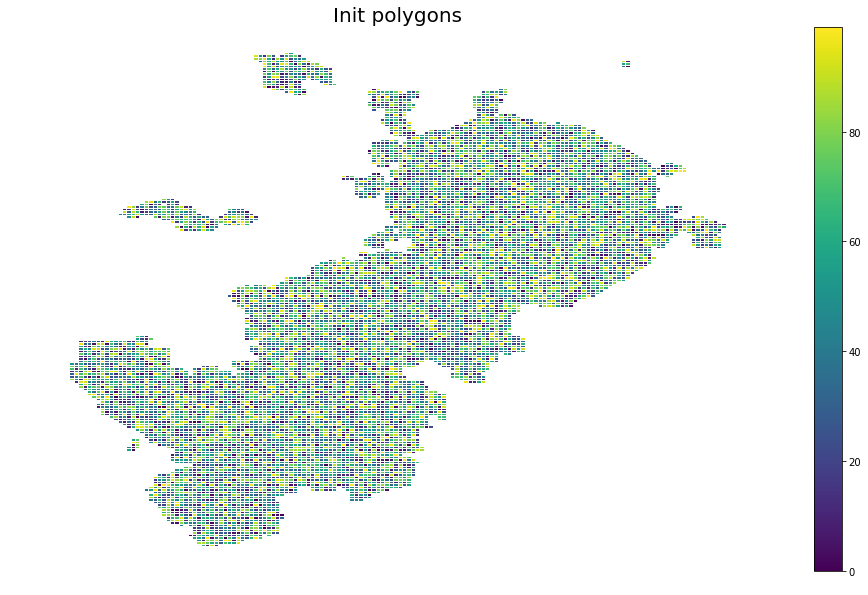

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

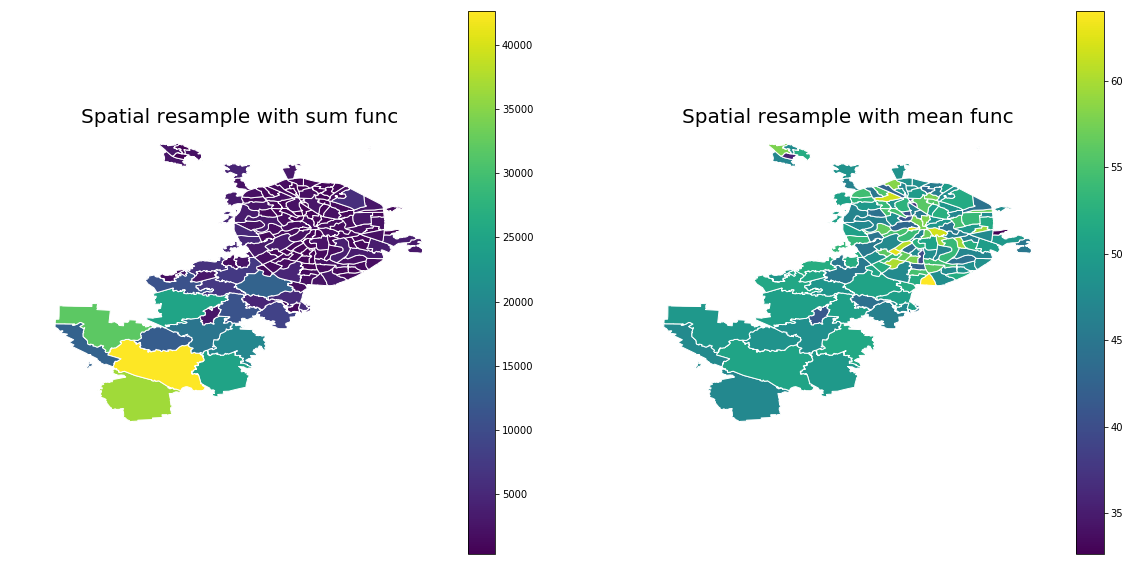

In [ ]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`

In [16]:
import folium
import geopy # объединенное API для популярных гео-кодирующих сервисов
from geopy.geocoders import Yandex, GoogleV3

In [30]:
from folium.features import DivIcon
import json

In [62]:
# выводим k_nearest_neighbours_by_centroid
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=10)
folium.Choropleth(big_moscow_districts, fill_color='white', line_color='black', name="Карта Москвы").add_to(m)
folium.Choropleth(k_nearest_neighbours_by_centroid, fill_color='red', line_color='black', name="К ближайших соседей").add_to(m)
folium.Choropleth(polygon, fill_color='green', line_color='black', name="Анализируемый АО").add_to(m)
m

In [63]:
# выводим k_nearest_neighbours_by_board
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=10)
folium.Choropleth(big_moscow_districts, fill_color='white', line_color='black', name="Карта Москвы").add_to(m)
folium.Choropleth(k_nearest_neighbours_by_board, fill_color='red', line_color='black', name="К ближайших соседей").add_to(m)
folium.Choropleth(polygon, fill_color='green', line_color='black', name="Анализируемый АО").add_to(m)
m